In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, spearmanr, pearsonr, chi2_contingency
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.api import OLS, add_constant
from google.colab import files
import os



In [ ]:
df = pd.read_excel("dataset.xlsx")
df.head()

In [ ]:
# Droped unwanted columns
df.columns = df.columns.str.strip()
df = df.drop(columns=[
    'Timestamp',
    'Email:',
    '4.What kind of pet(s) do you have?',
    '5. How long have you had your pet(s)?',
    '10. Tell us one moment when your pet truly made your day better.',
], errors='ignore')

In [ ]:
df.head()

,Age,Gender,Has_Pet,Joy_level,Stress_Relief_Frequency,Active,Social,Agree_Pets_Benefit_Overall
0,21,Female,Yes,5,Always,Yes,Yes,10
1,22,Female,Yes,5,Always,Yes,A little,10
2,22,Female,Yes,5,Always,No,Yes,10
3,22,Prefer not to say,No,2,Sometimes,No,No,10
4,24,Female,No,3,Rarely,No,No,7


In [ ]:
print(df.columns.tolist())


['Age', 'Gender', 'Has_Pet', 'Joy_level', 'Stress_Relief_Frequency', 'Active', 'Social', 'Agree_Pets_Benefit_Overall']


In [ ]:
# encoding values
# Gender
gender_mapping = {
    'Male': 0,
    'Female': 1,
    'Prefer not to say': 2
}
df['Gender'] = df['Gender'].map(gender_mapping)

# Currently own a pet
own_pet_mapping = {
    'No': 0,
    'Yes': 1
}
df['Has_Pet'] = df['Has_Pet'].map(own_pet_mapping)

# Mood improvement frequency
mood_mapping = {
    'Never': 0,
    'Rarely': 1,
    'Sometimes': 2,
    'Often': 3,
    'Always': 4
}
df['Stress_Relief_Frequency'] = df['Stress_Relief_Frequency'].map(mood_mapping)

# Outdoor activity
outdoor_mapping = {
    'No': 0,
    'Not sure': 1,
    'A little': 2,
    'Yes': 3
}
df['Active'] = df['Active'].map(outdoor_mapping)

# Social impact
social_mapping = {
    'No': 0,
    'A little': 1,
    'Yes': 2
}
df['Social'] = df['Social'].map(social_mapping)


# Overall agreement: convert to numeric
df['Agree_Pets_Benefit_Overall'] = pd.to_numeric(
    df['Agree_Pets_Benefit_Overall'],
    errors='coerce'
)



In [ ]:
df.head()

,Age,Gender,Has_Pet,Joy_level,Stress_Relief_Frequency,Active,Social,Agree_Pets_Benefit_Overall
0,21,1,1,5,4,3,2,10
1,22,1,1,5,4,3,1,10
2,22,1,1,5,4,0,2,10
3,22,2,0,2,2,0,0,10
4,24,1,0,3,1,0,0,7


In [ ]:
# droped rows with null values
df.dropna(inplace=True)
df.head()

,Age,Gender,Has_Pet,Joy_level,Stress_Relief_Frequency,Active,Social,Agree_Pets_Benefit_Overall
0,21,1,1,5,4,3,2,10
1,22,1,1,5,4,3,1,10
2,22,1,1,5,4,0,2,10
3,22,2,0,2,2,0,0,10
4,24,1,0,3,1,0,0,7


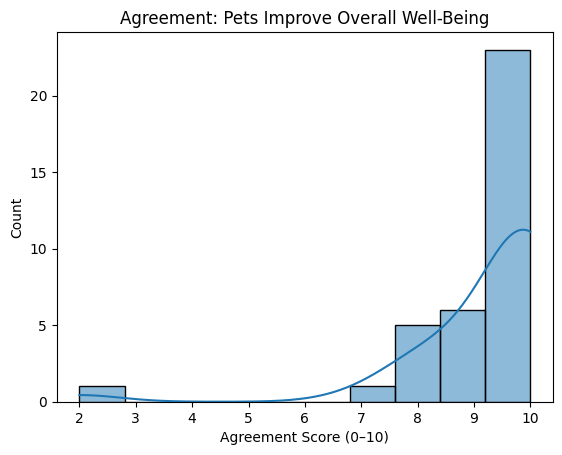

In [ ]:
# Distribution of Agreement Score
sns.histplot(df['Agree_Pets_Benefit_Overall'], bins=10, kde=True)
plt.title("Agreement: Pets Improve Overall Well-Being")
plt.xlabel("Agreement Score (0–10)")
plt.ylabel("Count")
plt.show()


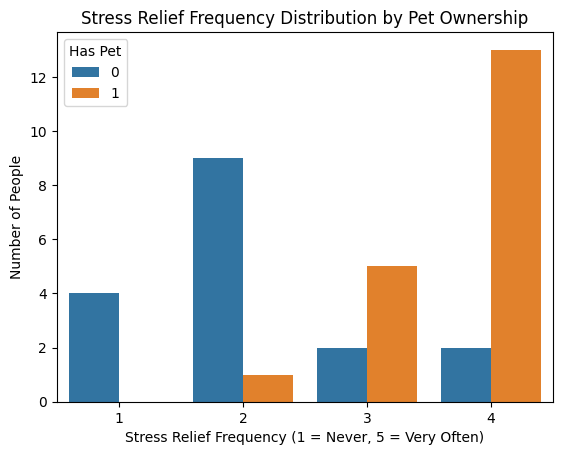

In [ ]:
sns.countplot(x='Stress_Relief_Frequency', hue='Has_Pet', data=df)
plt.title("Stress Relief Frequency Distribution by Pet Ownership")
plt.xlabel("Stress Relief Frequency (1 = Never, 5 = Very Often)")
plt.ylabel("Number of People")
plt.legend(title="Has Pet")
plt.show()


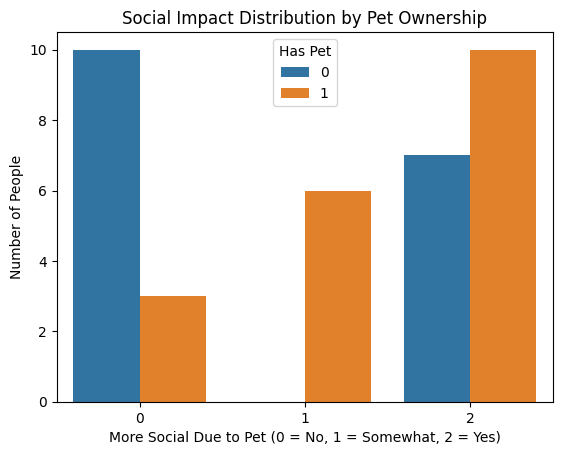

In [ ]:
sns.countplot(x='Social', hue='Has_Pet', data=df)
plt.title("Social Impact Distribution by Pet Ownership")
plt.xlabel("More Social Due to Pet (0 = No, 1 = Somewhat, 2 = Yes)")
plt.ylabel("Number of People")
plt.legend(title="Has Pet")
plt.show()


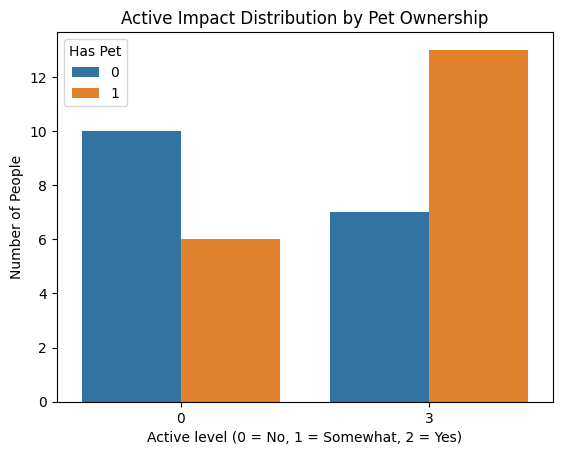

In [ ]:
sns.countplot(x='Active', hue='Has_Pet', data=df)
plt.title("Active Impact Distribution by Pet Ownership")
plt.xlabel("Active level (0 = No, 1 = Somewhat, 2 = Yes)")
plt.ylabel("Number of People")
plt.legend(title="Has Pet")
plt.show()


In [ ]:
correlation_features = df[[
    'Age',
    'Has_Pet',
    'Joy_level',
    'Stress_Relief_Frequency',
    'Active',
    'Social',
    'Agree_Pets_Benefit_Overall'
]]


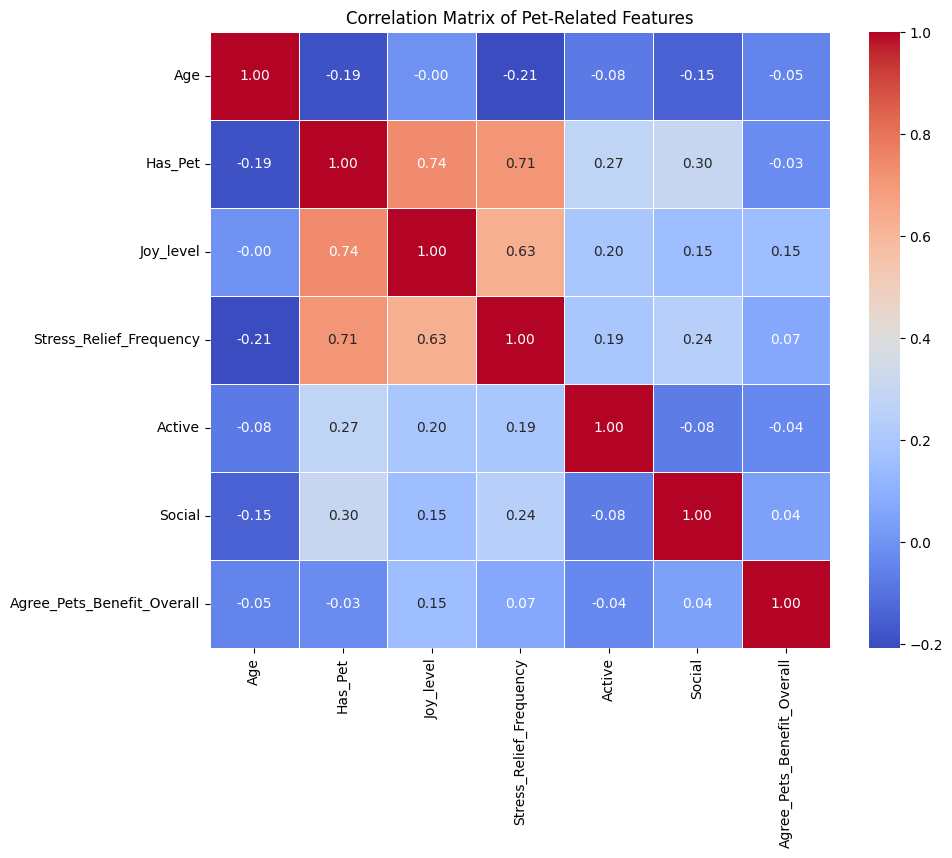

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = correlation_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Pet-Related Features")
plt.show()


In [ ]:
# H₀ (Null): Pets do not affect stress relief.
# H₁ (Alternative): Pets do help with stress relief.
# t-test
from scipy.stats import ttest_ind

# Splited data into groups
stress_pet = df[df['Has_Pet'] == 1]['Stress_Relief_Frequency']
stress_no_pet = df[df['Has_Pet'] == 0]['Stress_Relief_Frequency']

# Performed t-test
t_stat, p_val = ttest_ind(stress_pet, stress_no_pet, equal_var=False)

print(f"Stress Relief t-test:\nT-statistic = {t_stat:.3f}, p-value = {p_val:.3f}")


Stress Relief t-test:
T-statistic = 5.748, p-value = 0.000


In [ ]:
# Chi-Square Test: Are Pets Making Us More Social?

# Hypotheses
# Null Hypothesis (H₀): Pet ownership and social improvement are independent..

from scipy.stats import chi2_contingency
import pandas as pd

# Created contingency table
contingency = pd.crosstab(df['Has_Pet'], df['Social'])

# Performed chi-square test
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi-Square = {chi2:.3f}, p = {p:.3f}")


Chi-Square = 10.219, p = 0.006


In [ ]:
# Has_pet vs Joy_level
# Chi-Square Test: Are Pet Ownership and Being More Social Related?

# Hypotheses
# Null Hypothesis (H₀): Pet ownership and being more joyful  are independent (no relationship).
# Alternative Hypothesis (H₁): Pet ownership and being more joyful are not independent (there is a relationship).

from scipy.stats import chi2_contingency
import pandas as pd

# Created contingency table
contingency = pd.crosstab(df['Has_Pet'], df['Joy_level'])

# Performed chi-square test
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi-Square = {chi2:.3f}, p = {p:.3f}")


Chi-Square = 21.756, p = 0.000


In [ ]:
# Correlation Test: Do Has_Pet & Active Relate?
# H₀: No monotonic relationship between Has_Pet and Acitve
from scipy.stats import spearmanr

corr, p = spearmanr(df['Has_Pet'], df['Active'])
print(f"Spearman Correlation: {corr:.3f}, p = {p:.3f}")


Spearman Correlation: 0.274, p = 0.106
